In [3]:
import torch
import matplotlib.pyplot as plt
from torch import nn, Tensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchmetrics.image.fid import FrechetInceptionDistance

In [4]:
from torchvision import datasets, transforms
import torch

batch_size=64

digit = 8  #classe choisie
transform = transforms.Compose([transforms.ToTensor()])

mnist_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
indices = [i for i, label in enumerate(mnist_full.targets) if label == digit]
mnist_digit = torch.utils.data.Subset(mnist_full, indices)

train_loader = torch.utils.data.DataLoader(mnist_digit, batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


In [6]:
print("Nombre d'images dans les données choisies :",len(indices))

Nombre d'images dans les données choisies : 5851


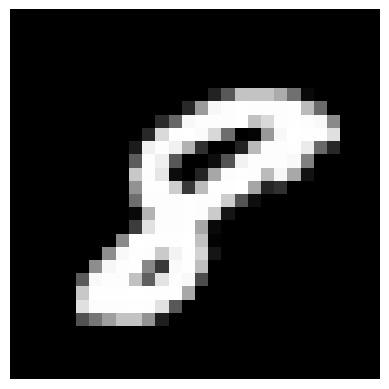

In [8]:
img, label = mnist_digit[80]
plt.imshow(img.squeeze(), cmap="gray")
plt.axis('off')
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


### Basic CNN

In [11]:
import CNN1 as CNN1
model = CNN1.CNN1()


In [14]:
n_epochs = 10000

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=50)
model = model.to(device)

for epoch in range(n_epochs):

    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).to(torch.float32)

    x_0 = torch.randn_like(x_1).to(device)

    t = torch.rand(batch_size, 1).to(device)

    x_t = (1 - t.view(-1, 1, 1, 1)) * x_0 + t.view(-1, 1, 1, 1) * x_1

    v_true = x_1 - x_0

    v_pred = model(x_t, t)

    loss = ((v_pred - v_true) ** 2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch} | loss = {loss.item():.4f}")

epoch 0 | loss = 1.1438
epoch 100 | loss = 0.4130
epoch 200 | loss = 0.4147
epoch 300 | loss = 0.2830
epoch 400 | loss = 0.2958
epoch 500 | loss = 0.2899
epoch 600 | loss = 0.2829
epoch 700 | loss = 0.2536
epoch 800 | loss = 0.2046
epoch 900 | loss = 0.2414
epoch 1000 | loss = 0.2341
epoch 1100 | loss = 0.2080
epoch 1200 | loss = 0.2268
epoch 1300 | loss = 0.2024
epoch 1400 | loss = 0.1849
epoch 1500 | loss = 0.2099
epoch 1600 | loss = 0.2012
epoch 1700 | loss = 0.1762
epoch 1800 | loss = 0.2099
epoch 1900 | loss = 0.1906
epoch 2000 | loss = 0.2129
epoch 2100 | loss = 0.1883
epoch 2200 | loss = 0.1647
epoch 2300 | loss = 0.2021
epoch 2400 | loss = 0.1730
epoch 2500 | loss = 0.1975
epoch 2600 | loss = 0.1643
epoch 2700 | loss = 0.1771
epoch 2800 | loss = 0.1801
epoch 2900 | loss = 0.1600
epoch 3000 | loss = 0.1576
epoch 3100 | loss = 0.1693
epoch 3200 | loss = 0.1660
epoch 3300 | loss = 0.1734
epoch 3400 | loss = 0.1828
epoch 3500 | loss = 0.1584
epoch 3600 | loss = 0.1590
epoch 3700 | 

In [15]:
def generate_image(model, steps=100, device="cuda"):

    x_t = torch.randn(1, 1, 28, 28, device=device)

    dt = 1.0 / steps

    for step in range(steps):
        t = torch.tensor([[1.0 - step*dt]], device=device)  # t décroissant de 1 à 0
        v = model(x_t, t)
        x_t = x_t + dt * v

    x_gen = torch.clip(x_t, 0.0, 1.0)
    return x_gen


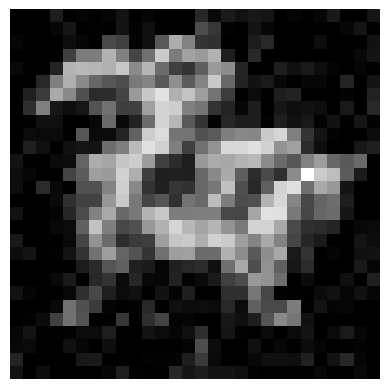

In [223]:
model = model.to(device)
x_gen = generate_image(model)
import matplotlib.pyplot as plt
plt.imshow(x_gen[0,0].cpu().detach(), cmap="gray")
plt.axis("off")
plt.show()

### Basic UNET

In [17]:
import UNET as UNET


model2 = UNET.UNet4()

In [19]:
n_epochs = 5000
model2 = model2.to(device)

optim = torch.optim.Adam(model2.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=50)


for epoch in range(n_epochs):

    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).to(torch.float32)

    x_0 = torch.randn_like(x_1).to(device)

    t = torch.rand(batch_size, 1).to(device)

    x_t = (1 - t.view(-1, 1, 1, 1)) * x_0 + t.view(-1, 1, 1, 1) * x_1

    v_true = x_1 - x_0

    v_pred = model2(x_t, t)

    loss = ((v_pred - v_true) ** 2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch % 200 == 0:
        print(f"epoch {epoch} | loss = {loss.item():.4f}")

epoch 0 | loss = 1.1188
epoch 200 | loss = 0.3713
epoch 400 | loss = 0.3486
epoch 600 | loss = 0.2841
epoch 800 | loss = 0.2887
epoch 1000 | loss = 0.2431
epoch 1200 | loss = 0.2046
epoch 1400 | loss = 0.1730
epoch 1600 | loss = 0.2151
epoch 1800 | loss = 0.1546
epoch 2000 | loss = 0.1951
epoch 2200 | loss = 0.1605
epoch 2400 | loss = 0.1617
epoch 2600 | loss = 0.1919
epoch 2800 | loss = 0.1703
epoch 3000 | loss = 0.1587
epoch 3200 | loss = 0.1703
epoch 3400 | loss = 0.1625
epoch 3600 | loss = 0.1283
epoch 3800 | loss = 0.1404
epoch 4000 | loss = 0.1516
epoch 4200 | loss = 0.1492
epoch 4400 | loss = 0.1256
epoch 4600 | loss = 0.1342
epoch 4800 | loss = 0.1409


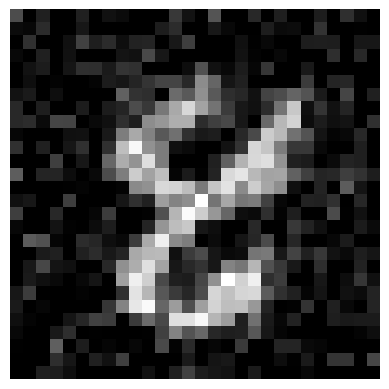

In [164]:
x_gen = generate_image(model2)
import matplotlib.pyplot as plt
plt.imshow(x_gen[0,0].cpu().detach(), cmap="gray")
plt.axis("off")
plt.show()

### UNET ChatGPT

In [165]:
import UNET_ChatGPT as UNET2


model3 = UNET2.UNetEnhanced()

In [166]:
n_epochs = 2000
model3 = model3.to(device)

optim = torch.optim.Adam(model3.parameters(), lr=0.001)

for epoch in range(n_epochs):

    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).to(torch.float32)

    x_0 = torch.randn_like(x_1).to(device)

    t = torch.rand(batch_size, 1).to(device)

    x_t = (1 - t.view(-1, 1, 1, 1)) * x_0 + t.view(-1, 1, 1, 1) * x_1

    v_true = x_1 - x_0

    v_pred = model3(x_t, t)

    loss = ((v_pred - v_true) ** 2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch} | loss = {loss.item():.4f}")

epoch 0 | loss = 1.2006
epoch 100 | loss = 0.1497
epoch 200 | loss = 0.1419
epoch 300 | loss = 0.1323
epoch 400 | loss = 0.1269
epoch 500 | loss = 0.1184
epoch 600 | loss = 0.1254
epoch 700 | loss = 0.1277
epoch 800 | loss = 0.1092
epoch 900 | loss = 0.1009
epoch 1000 | loss = 0.0950
epoch 1100 | loss = 0.1168
epoch 1200 | loss = 0.1170
epoch 1300 | loss = 0.1352
epoch 1400 | loss = 0.0934
epoch 1500 | loss = 0.0953
epoch 1600 | loss = 0.1036
epoch 1700 | loss = 0.0998
epoch 1800 | loss = 0.0965
epoch 1900 | loss = 0.1037


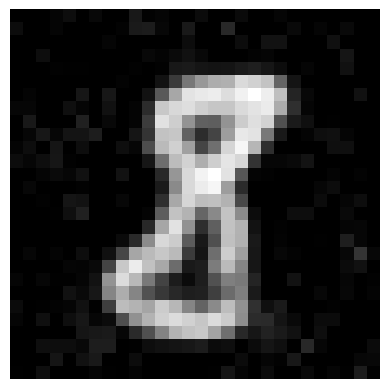

In [167]:
x_gen = generate_image(model3)
import matplotlib.pyplot as plt
plt.imshow(x_gen[0,0].cpu().detach(), cmap="gray")
plt.axis("off")
plt.show()

### Unet OPENAI

In [171]:
import unet_OPENAI as UNET_OAI

model4 = UNET_OAI.UNetModel(
    image_size=28,
    in_channels=1,                # RGB
    model_channels=96,           # largeur du UNet
    out_channels=1,               # reconstruit 3 canaux
    num_res_blocks=2,             # 1 ou 2, 2 donne + de qualité
    attention_resolutions=[8],   # attention à 16x16
    channel_mult=[1, 2],
    dropout=0.1,                  # léger dropout
    use_checkpoint=True,         # mettre True si GPU faible
)

In [172]:
from nn import timestep_embedding

n_epochs = 1000
model4 = model4.to(device)
optim = torch.optim.Adam(model4.parameters(), 0.001)

for epoch in range(n_epochs):

    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).float()

    x_0 = torch.randn_like(x_1)

    B = x_1.size(0)

    t = torch.rand(B, device=device)

    # Interpolation
    x_t = (1 - t.view(B,1,1,1)) * x_0 + t.view(B,1,1,1) * x_1

    # Champ de vecteur "réel"
    v_true = x_1 - x_0

    # Embedding temporel
    v_pred = model4(x_t, t * 1000)


    # Loss
    loss = ((v_pred - v_true) ** 2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if(epoch%50 == 0):
        print(f"[epoch {epoch}] loss = {loss.item():.4f}")


[epoch 0] loss = 1.1277
[epoch 50] loss = 0.1777
[epoch 100] loss = 0.1308
[epoch 150] loss = 0.1204
[epoch 200] loss = 0.1370
[epoch 250] loss = 0.1160
[epoch 300] loss = 0.1036
[epoch 350] loss = 0.1108
[epoch 400] loss = 0.1135
[epoch 450] loss = 0.1062
[epoch 500] loss = 0.1069
[epoch 550] loss = 0.1000
[epoch 600] loss = 0.1203
[epoch 650] loss = 0.1086
[epoch 700] loss = 0.1151
[epoch 750] loss = 0.1048
[epoch 800] loss = 0.0982
[epoch 850] loss = 0.0957
[epoch 900] loss = 0.0943
[epoch 950] loss = 0.1012


In [173]:
import torch

def generate_image2(model, steps=100, device="cuda"):

    x_t = torch.randn(1, 1, 28, 28, device=device)
    dt = 1.0 / steps

    for step in range(steps):
        t_float = step * dt
        # convertir en entier pour l'embedding timestep
        if step == 0:
            print(t_float)
        t_int = torch.tensor([int(t_float * 1000)], device=device)
        v = model(x_t, t_int)
        x_t = x_t + dt * v

    x_gen = torch.clamp(x_t, 0.0, 1.0)
    img = x_gen[0].permute(1, 2, 0).cpu().detach().numpy()

    return x_gen




0.0


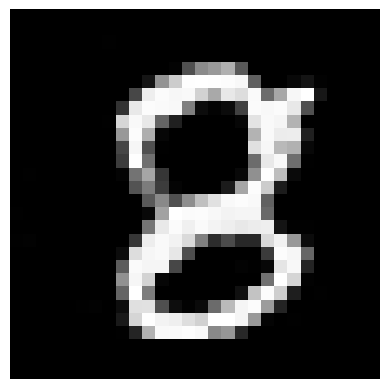

In [179]:
x_gen_OAI = generate_image2(model4)
import matplotlib.pyplot as plt
plt.imshow(x_gen_OAI[0,0].cpu().detach(), cmap="gray")
plt.axis("off")
plt.show()